<a href="https://colab.research.google.com/github/baovin/ML_homework/blob/main/ensemble_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BTVN: Training Neural Networks (Tiếp)
Trong phần này các bạn sẽ làm quen với kỹ thuật model ensemble để tăng độ chính xác khi suy diễn

In [1]:
!nvidia-smi
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable
import os

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

Wed Sep  4 10:23:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Tải dữ liệu và cài đặt một kiến trúc mạng nơ-ron đơn giản theo mô tả phía dưới

Bộ dữ liệu sử dụng là bộ CIFAR10 gồm 6000 ảnh màu đã được gán nhãn có kích thước cố định là 32*32

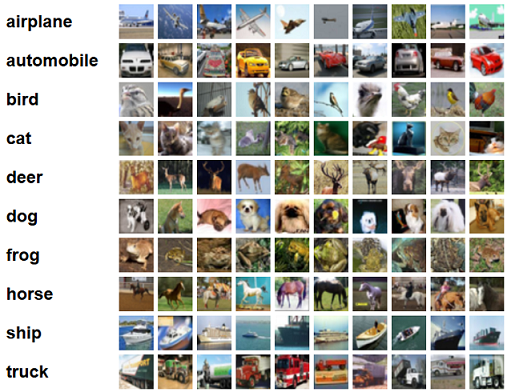

In [6]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset


class Net(nn.Module):
    ######################
    ### YOUR CODE HERE ###
    ######################

    def __init__(self, l1=64, l2=32):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    ######################
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model = Net()
if torch.cuda.is_available():
    model.cuda()
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


Hàm đánh giá độ chính xác trên tập test

In [7]:
def test_accuracy(net, device="cpu"):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            ######################

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            ######################
            ### YOUR CODE HERE ###
            ######################

    return correct / total

Hàm huấn luyện mô hình

In [11]:
def train(net, criterion, optimizer, save_path, device="cpu"):
    if torch.cuda.is_available():
        device = "cuda"
    T_cur = 0
    for epoch in range(1, epochs+1):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        T_cur += 1

        # warm-up
        if epoch <= warm_epoch:
            optimizer.param_groups[0]['lr'] = (1.0 * epoch) / warm_epoch  * init_lr
        else:
            # cosine annealing lr
            optimizer.param_groups[0]['lr'] = last_lr + (init_lr - last_lr) * (1 + np.cos(T_cur * np.pi / T_max)) / 2

        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i + 1 == len(trainloader):
                print("[Epoch %d] loss: %.3f" % (epoch, running_loss / epoch_steps))
                running_loss = 0.0

    print("Finished Training")
    print("Test accuracy:", test_accuracy(net, device))
    torch.save(net.state_dict(), save_path)

Thiết lập các tham số và hai kiến trúc mạng khác nhau

In [12]:
epochs = 10
warm_epoch = 5
init_lr = 1e-2
last_lr = 1e-4
T_max = epochs

configs = [{'l1': 64, 'l2': 32}, {'l1': 128, 'l2': 64}]

trainset, testset = load_data('./data')
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=128,
    shuffle=True,
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Huấn luyện hai mạng mô tả trong configs

In [13]:
os.makedirs('./snapshot', exist_ok=True)

for i, cfg in enumerate(configs):
    print(cfg)
    net = Net(cfg['l1'], cfg['l2'])

    if torch.cuda.is_available():
        net.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=init_lr, momentum=0.9)
    train(net, criterion, optimizer, f'./snapshot/model{i}.pth')
    ######################
    ### YOUR CODE HERE ###
    ######################

{'l1': 64, 'l2': 32}
[Epoch 1] loss: 2.294
[Epoch 2] loss: 1.998
[Epoch 3] loss: 1.662
[Epoch 4] loss: 1.464
[Epoch 5] loss: 1.349
[Epoch 6] loss: 1.199
[Epoch 7] loss: 1.140
[Epoch 8] loss: 1.099
[Epoch 9] loss: 1.077
[Epoch 10] loss: 1.068
Finished Training
Test accuracy: 0.5919
{'l1': 128, 'l2': 64}
[Epoch 1] loss: 2.300
[Epoch 2] loss: 2.113
[Epoch 3] loss: 1.736
[Epoch 4] loss: 1.544
[Epoch 5] loss: 1.421
[Epoch 6] loss: 1.275
[Epoch 7] loss: 1.214
[Epoch 8] loss: 1.173
[Epoch 9] loss: 1.150
[Epoch 10] loss: 1.141
Finished Training
Test accuracy: 0.5702


Kết hợp kết quả hai mạng (ensemble)

In [14]:
from tqdm import tqdm

def test_ensemble(device="cuda:0"):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            final_outputs = torch.zeros((4, 10)).to(device)
            for i, cfg in enumerate(configs):
                net = Net(cfg['l1'], cfg['l2'])
                net.to(device)
                net.load_state_dict(torch.load(f'./snapshot/model{i}.pth'))
                outputs = net(images)
                final_outputs = final_outputs.add(outputs)

            final_outputs.div(len(configs))
            _, predicted = torch.max(final_outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [15]:
from tqdm import tqdm

def test_ensemble(device="cuda:0"):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            final_outputs = torch.zeros((4, 10)).to(device)
            for i, cfg in enumerate(configs):
                net = Net(cfg['l1'], cfg['l2'])
                net.to(device)
                net.load_state_dict(torch.load(f'./snapshot/model{i}.pth'))
                outputs = net(images)
                final_outputs = final_outputs.add(outputs)

            final_outputs.div(len(configs))
            _, predicted = torch.max(final_outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [16]:
test_ensemble()

  0%|          | 0/2500 [00:00<?, ?it/s]<ipython-input-15-1eb7823dc4a5>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(f'./snapshot/model{i

0.6064